# Process Koppen climate zones dataset 

gdal_translate -of "GTiff" kpngrp.txt kpngrp.tif

In [1]:
import rioxarray as rxr
import xarray as xr
import numpy as np
from odc.geo.xr import assign_crs

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
koppen = rxr.open_rasterio('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/kpngrp.tif').squeeze().drop_vars('band')
koppen = koppen.where(koppen>-9999)

# Dataset to reproject too and land-sea mask
rain = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/rain_5km_monthly_1981_2022.nc')['rain']
rain = rain.sel(time=slice('2000', '2010')).mean('time')
mask = (~np.isnan(rain))
gbox=rain.odc.geobox

## Reclasssify

In [3]:
desert = [21,22,23,24]
grassland = [11,12,13,14,15]
temperate = [1,2,3,4,5,6,7,8,9]
subtropical = [31,32,33,34]
tropical = [35,36,37]
equatorial = [41,42]

regions = {i:r for i,r in zip(range(50,57), [desert,grassland,temperate,subtropical,tropical,equatorial])}

for k,r in regions.items():
    koppen = xr.where(koppen.isin(r), k, koppen)

koppen = assign_crs(koppen, crs='epsg:4326')
koppen = koppen.odc.reproject(gbox,resampling='mode')
koppen = round_coords(koppen)
koppen = assign_crs(koppen, crs='epsg:4326')
koppen = koppen.where(mask)

## Export

In [4]:
koppen.to_netcdf('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/koppen_major_climate_zones.nc')

## Plot

In [5]:
import distinctipy
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap

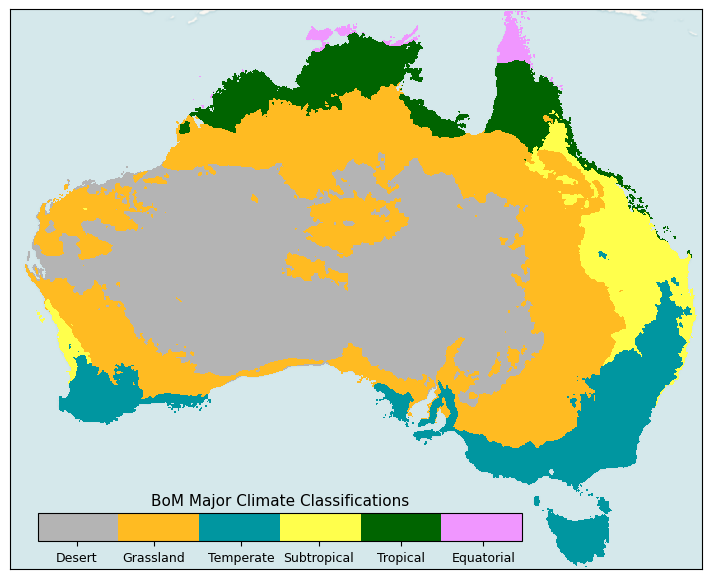

In [6]:
fig,ax = plt.subplots(1,1, figsize=(7,6), layout='constrained')

categories =['Desert', 'Grassland', 'Temperate', 'Subtropical', 'Tropical', 'Equatorial']
# categories =['Equatorial', 'Tropical','Subtropical', 'Temperate','Grassland', 'Desert']
colours = ['#b4b4b4',  '#ffbb22',   '#0096a0',     '#ffff4c',  '#006400'  ,   '#f096ff'] # '#0096a0', '#00cf75',  '#ffff4c'
# colours = ['#fa0000','#f096ff','#b4b4b4', '#ffff4c', '#0096a0', '#ffbb22'] # '#0096a0', '#00cf75',  '#ffff4c'
        # 
cmap = LinearSegmentedColormap.from_list("landcover_cmap", colours, N=len(colours))

im = koppen.plot(cmap=cmap, ax=ax, add_colorbar=False, add_labels=False)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

axins1 = inset_axes(ax,width="70%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1, ticks=[50.4, 51.20, 52.1, 52.9, 53.75, 54.6], orientation='horizontal')
cbar.ax.set_title('BoM Major Climate Classifications', fontsize=11);
cbar.ax.set_xticklabels(categories, fontsize=9);